In [1]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
from h3 import h3
import datetime
import os, inspect
import matplotlib.pyplot as plt
import importlib
importlib.reload(a)

<module 'analysis' from '../analysis.py'>

# 0. Connect to Mongo and define a specific database

In [2]:
db=commu.connecttoLocaldb(database='twitter')

# 1. Obtaining hexcounts from database

In [3]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

1.4117138385772705


# 2 Total (complete history) tweets per typology procedure

## 2.1. Prepare a second dataframe with total tweets per hex  

In [4]:
df_totals=df.groupby('_id').sum()
df_totals.reset_index(inplace=True)

## 2.2 Spatial join with typologies

In [5]:
#1 Get centroids
df_totals=myh3.df_with_hexid_to_centroids_gdf(df_totals, hexcolname='_id')

In [6]:
# Spatial Join
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
tracts = gpd.read_file(currentdir+'/../data/radios_amba_2010.shp')

# Spatial Join between centroids and census track shapes
df_totals=gpd.sjoin(df_totals, tracts, how="inner", op='intersects')



# Since in my case I do not have the typologies with the census tract data, I still need to merge it by censustrackid
typologies=pd.read_excel(currentdir+'/../data/tipologias/'+'tipologias.xlsx')


typologies.loc[typologies['TYPE']=='GDV','TYPE' ]="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GD','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='G','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='DV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='D','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='VE','TYPE']="Exclusive Dynamic"
typologies.loc[typologies['TYPE']=='V','TYPE']="Low Income, At Risk of Change"
typologies.loc[typologies['TYPE']=='E','TYPE']="Exclusive Static"


df_totals=df_totals.merge(typologies[['COD_2010','TYPE']], left_on='cod_radio', right_on='COD_2010')

/home/rickhunter/miniconda3/envs/twitteranalysis/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [36]:
df_totals.head(3)

,_id,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,geometry,index_right,cod_radio,formula,varon,...,tipo,cloc_urb,nom_urb,cloc_agrup,nom_agrup,cloc_dispe,nom_disper,localidad,COD_2010,TYPE
0,89dd6b80043ffff,2856.0,2749.0,222.0,3078.0,POINT (-58.38501440888357 -34.6505108024536),3288,20041103,a020041103,370,...,U,4.0,COMUNA 04,NaN,None,NaN,None,CABA,20041103,"Low Income, Undergoing Change"
1,89dd6b80047ffff,809.0,790.0,2.0,811.0,POINT (-58.38294338434664 -34.65527546577988),3346,20041109,a020041109,435,...,U,4.0,COMUNA 04,NaN,None,NaN,None,CABA,20041109,"Low Income, At Risk of Change"
2,89dd6b80057ffff,490.0,402.0,7.0,497.0,POINT (-58.38605246881433 -34.65646264229747),3346,20041109,a020041109,435,...,U,4.0,COMUNA 04,NaN,None,NaN,None,CABA,20041109,"Low Income, At Risk of Change"


## 2.3 Total number of tweets per typology

In [34]:
stats1=df_totals[['nonresidents', 'nonresidentsandnonneighbors', 'residents', 'totalcounts', 'TYPE']].groupby('TYPE').agg([ 'sum'])
stats1.reset_index(inplace=True)
stats1=stats1.sort_values(by=('totalcounts','sum'), ascending=False)

stats1=stats1.loc[typo_stats.TYPE!='NON_POP']
stats1=stats1.loc[typo_stats.TYPE!='NON POP']
stats1=stats1.loc[typo_stats.TYPE!='OTHER']
stats1

,TYPE,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
,,sum,sum,sum,sum
3,"Low Income, Undergoing Change",4145772.0,3912139.0,408657.0,4554429.0
1,Exclusive Static,1459175.0,1411034.0,89869.0,1549044.0
2,"Low Income, At Risk of Change",713290.0,666399.0,86534.0,799824.0
0,Exclusive Dynamic,250740.0,242895.0,14995.0,265735.0


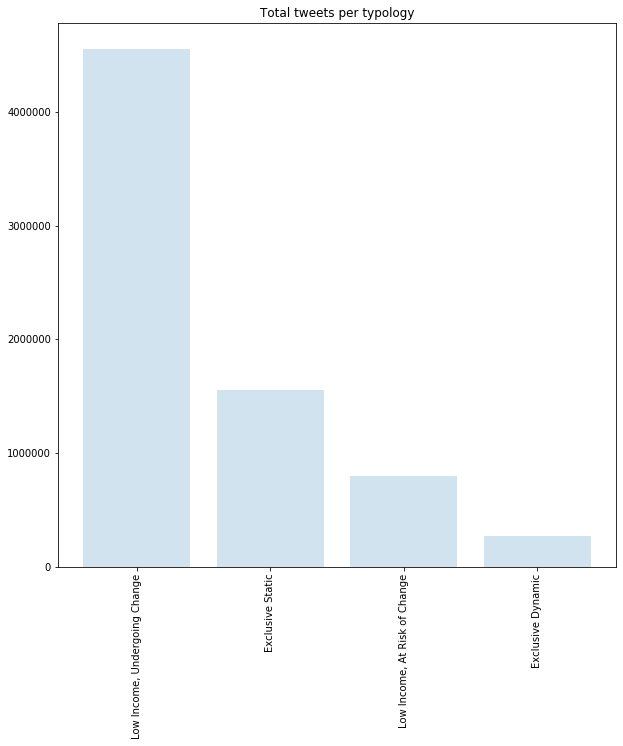

In [35]:

fig, ax = plt.subplots()
ax.bar(stats1['TYPE'], stats1['totalcounts','sum'], alpha=0.2)
plt.title('Total tweets per typology')
plt.xticks(rotation=90) 
plt.show()


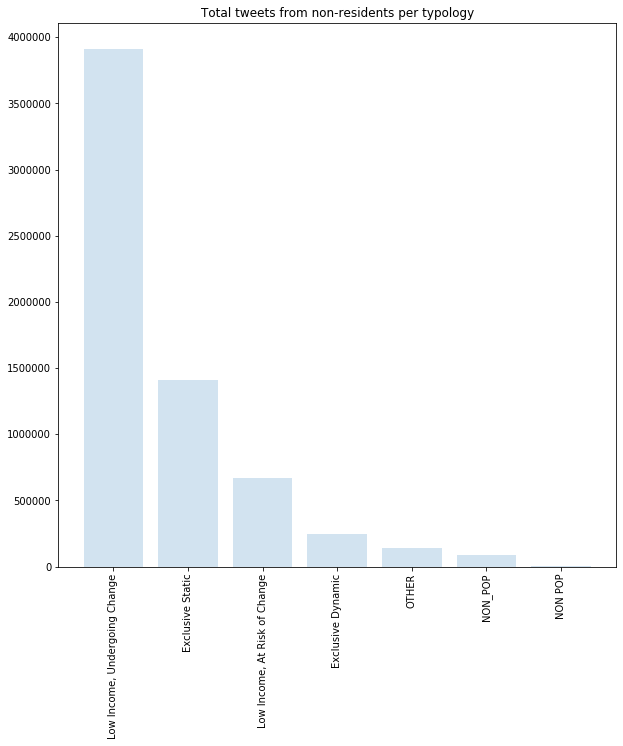

In [10]:
fig, ax = plt.subplots()
plt.title('Total tweets from non-residents per typology')
ax.bar(stats1['TYPE'], stats1['nonresidentsandnonneighbors','sum'], alpha=0.2)
plt.xticks(rotation=90) 
plt.show()

## 2.4 Hex-level statistics of the total number of tweets (complete period)

In [32]:
stats2=df_totals[['nonresidents', 'nonresidentsandnonneighbors', 'residents', 'totalcounts', 'TYPE']].groupby('TYPE').agg(['mean','sem', 'median', 'count'])
stats2.reset_index(inplace=True)
stats2=stats2.sort_values(by=('nonresidentsandnonneighbors','mean'), ascending=False)
#removing categories from graph
stats2=stats2.loc[typo_stats.TYPE!='NON_POP']
stats2=stats2.loc[typo_stats.TYPE!='NON POP']
stats2=stats2.loc[typo_stats.TYPE!='OTHER']
stats2

TYPE  nonresidents                              \
                                          mean          sem   median count   
0              Exclusive Dynamic  15671.250000  2132.819979  15765.5    16   
1               Exclusive Static  12365.889831   612.968203  11340.0   118   
3  Low Income, Undergoing Change   5782.108787   176.887739   4701.0   717   
2  Low Income, At Risk of Change   3364.575472   243.696762   2322.5   212   

  nonresidentsandnonneighbors                               residents  \
                         mean          sem   median count        mean   
0                15180.937500  2129.667991  15093.5    16  937.187500   
1                11957.915254   595.412854  10952.5   118  761.601695   
3                 5456.260809   173.116837   4386.0   717  569.953975   
2                 3143.391509   235.152023   2111.5   212  408.179245   

                             totalcounts                              
          sem median count          mean          sem   median count  
0  145.239693  832.5    16  16608.437500  2179.640016  16375.0    16  
1   49.279056  604.0   118  13127.491525   641.790475  11880.5   118  
3   23.819225  372.0   717   6352.062762   186.350398   5251.0   717  
2   47.360259  175.0   212   3772.754717   265.733000   2508.5   212

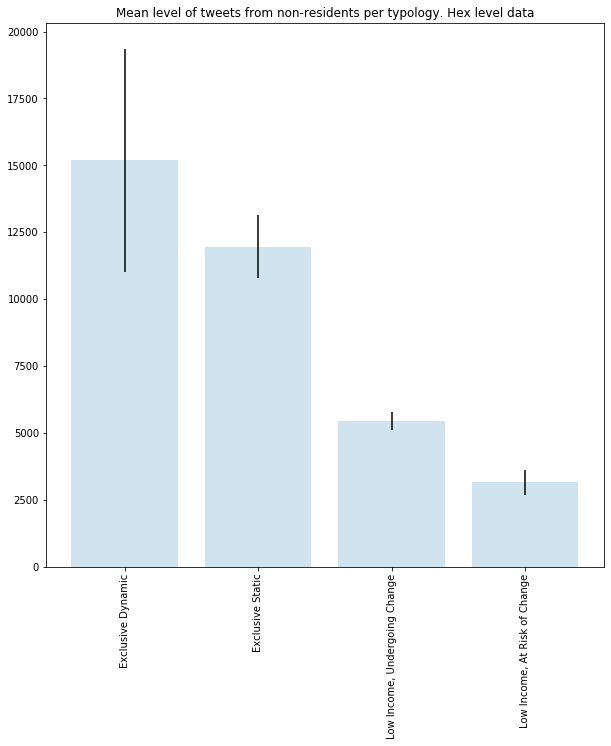

In [33]:
fig, ax = plt.subplots()
plt.title('Mean level of tweets from non-residents per typology. Hex level data')
ax.bar(stats2['TYPE'], stats2['nonresidentsandnonneighbors','mean'], yerr=1.96*stats2['nonresidentsandnonneighbors','sem'], alpha=0.2)
plt.xticks(rotation=90) 
plt.show()

# 3. Statistics splitting the sample in two time periods and computing time changes (i.e., before-after) 

We will divide the period available time period in two, average the counts for the two resulting subperiods, and compute the changes between periods. The result is a dataframe at the hex_id level. 
The result is also a GeoDataFrame ready to plot


## 3.1 Compute changes
Note: changes can be computed by first averaging the quarter level data of each period, or alternatively, by summing the data in each period. We will start by averaging which is the default option in a.percent_change_two_periods function

In [13]:
# Tweets are counted in time intervals defined in the tweets counts function. The default is quarterly data. 
# 1. Check first the available dates in the counts
df.time.unique()

array(['2013-12-31T00:00:00.000000000', '2014-03-31T00:00:00.000000000',
       '2013-09-30T00:00:00.000000000', '2013-06-30T00:00:00.000000000',
       '2013-03-31T00:00:00.000000000', '2012-12-31T00:00:00.000000000',
       '2012-09-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
# 2 Define a midpoint date to separate the two periods in the data. Remember here to change the datetime to the midpoint date in the previous step.
gdfchanges=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2013,6,30))

Coding \
_p0 is the average level of tweets counts in the first period   \
_dif is the difference between periods \
_ch stands for % changes \
_chb is an alternative % change only for those hexs with more than 50 tweets.

In [15]:
gdfchanges.head(3)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,89dd68212a3ffff,-2.5,-2.5,NaN,-2.5,13.0,13.0,NaN,13.0,-0.192308,-0.192308,NaN,-0.192308,NaN,NaN,NaN,NaN,POLYGON ((-58.7353320478173 -34.93557968986994...
1,89dd68213c3ffff,0.0,0.0,NaN,0.0,2.0,2.0,NaN,2.0,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN,POLYGON ((-58.72803634551494 -34.9439497165329...
2,89dd6828127ffff,31.0,31.0,NaN,31.0,1.0,1.0,NaN,1.0,31.000000,31.000000,NaN,31.000000,NaN,NaN,NaN,NaN,POLYGON ((-58.66791142993532 -34.8304449736193...


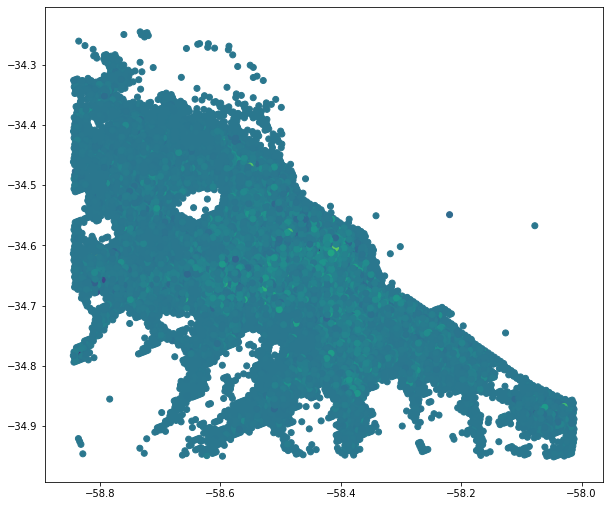

In [81]:
# Plot example
gdfchanges.plot('nonresidents_dif')

## 3.2. Spatial join with census tracks (typologies) data

This requires: 
1. An available function changes the geometry of the gdf to the centroids 
2. Load your typologies data to a geodataframe
3. Spatial join


In [17]:
#1 Get centroids
gdfchanges_points=myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

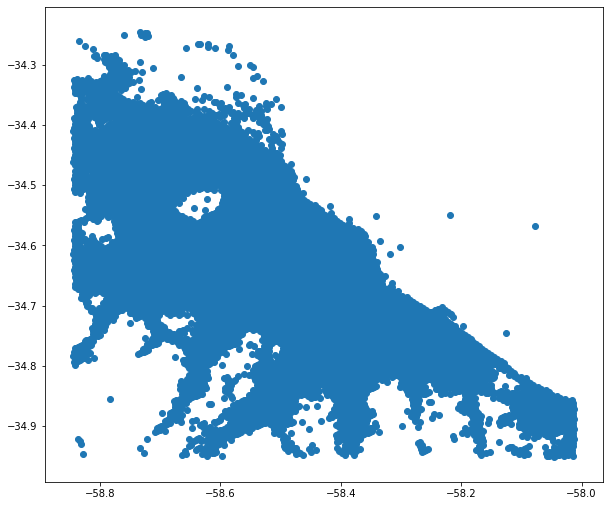

In [18]:
gdfchanges_points.plot()

In [19]:
# Load your typologies data as a geodataframe 
import os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
tracts = gpd.read_file(currentdir+'/../data/radios_amba_2010.shp')

# 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

/home/rickhunter/miniconda3/envs/twitteranalysis/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [20]:
# Since in my case I do not have the typologies with the census tract data, I still need to merge it by censustrackid
typologies=pd.read_excel(currentdir+'/../data/tipologias/'+'tipologias.xlsx')
typologies.loc[typologies['TYPE']=='GDV','TYPE' ]="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GD','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='G','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='DV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='D','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='VE','TYPE']="Exclusive Dynamic"
typologies.loc[typologies['TYPE']=='V','TYPE']="Low Income, At Risk of Change"
typologies.loc[typologies['TYPE']=='E','TYPE']="Exclusive Static"
tweets_tracts=tweets_tracts.merge(typologies[['COD_2010','TYPE']], left_on='cod_radio', right_on='COD_2010')

In [21]:
tweets_tracts.head()

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,...,tipo,cloc_urb,nom_urb,cloc_agrup,nom_agrup,cloc_dispe,nom_disper,localidad,COD_2010,TYPE
0,89dd6b80043ffff,560.000000,527.833333,62.916667,622.916667,168.00,166.50,4.75,172.75,3.333333,...,U,4.0,COMUNA 04,NaN,None,NaN,None,CABA,20041103,"Low Income, Undergoing Change"
1,89dd6b80047ffff,183.250000,188.000000,NaN,184.250000,73.75,69.00,NaN,73.75,2.484746,...,U,4.0,COMUNA 04,NaN,None,NaN,None,CABA,20041109,"Low Income, At Risk of Change"
2,89dd6b80057ffff,62.750000,52.500000,NaN,66.250000,60.75,49.50,NaN,60.75,1.032922,...,U,4.0,COMUNA 04,NaN,None,NaN,None,CABA,20041109,"Low Income, At Risk of Change"
3,89dd6b8004bffff,213.166667,213.000000,NaN,214.833333,109.50,108.00,NaN,109.50,1.946728,...,U,4.0,COMUNA 04,NaN,None,NaN,None,CABA,20041206,"Low Income, At Risk of Change"
4,89dd6b8005bffff,167.083333,145.416667,194.000000,297.166667,144.25,143.25,4.50,146.50,1.158290,...,U,4.0,COMUNA 04,NaN,None,NaN,None,CABA,20041206,"Low Income, At Risk of Change"


## 3.3 Aggregating counts by typologies

In [22]:
typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'TYPE']].groupby('TYPE').agg(['mean','count','sem'])
typo_stats.reset_index(inplace=True)

In [29]:
def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'TYPE']].groupby('TYPE').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.TYPE!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.TYPE!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.TYPE!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['TYPE'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()


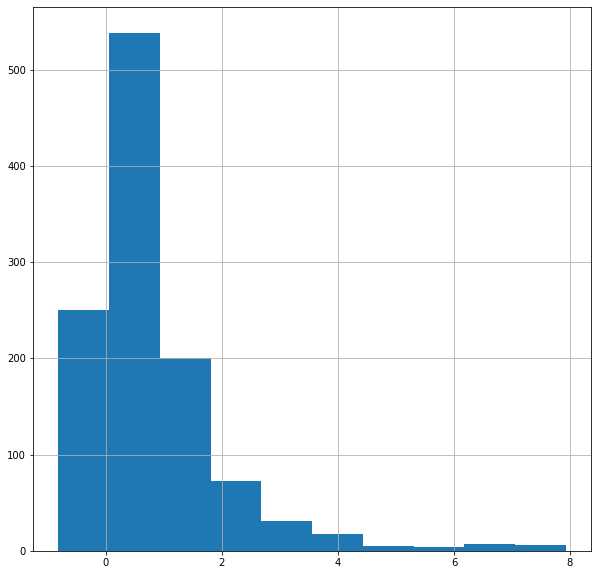

In [24]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

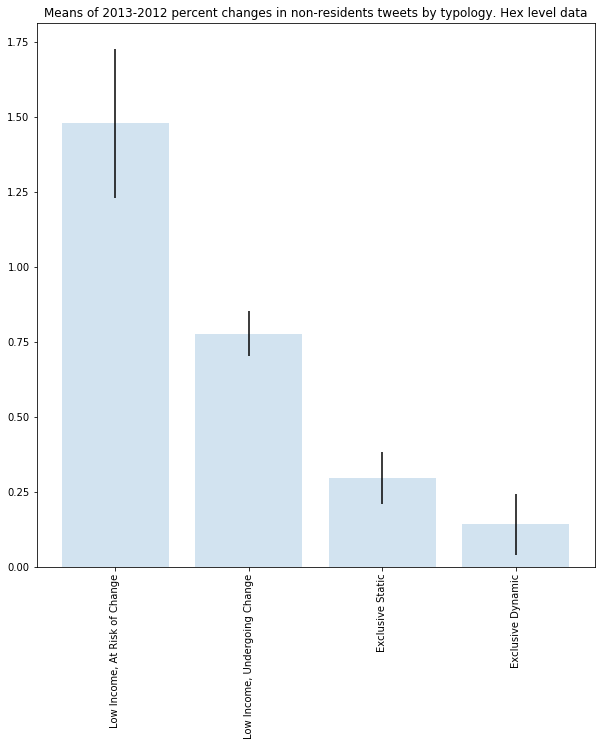

In [30]:
barchart(tweets_tracts, 'nonresidents_ch', title='Means of 2013-2012 percent changes in non-residents tweets by typology. Hex level data')

### Repeat analysis summing tweets in each period

/home/rickhunter/miniconda3/envs/twitteranalysis/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


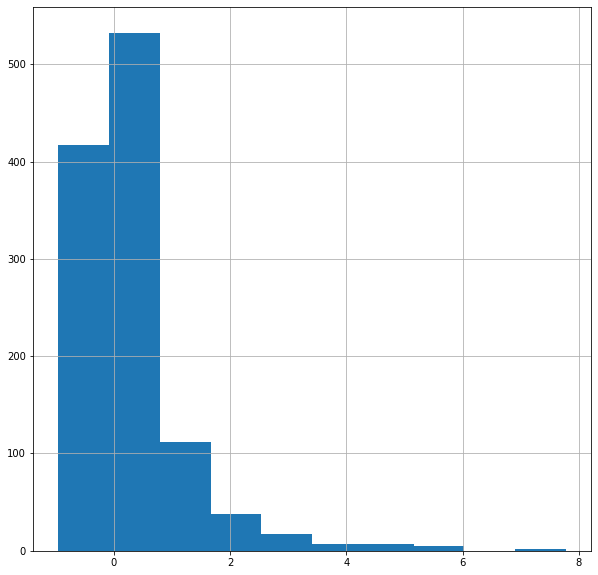

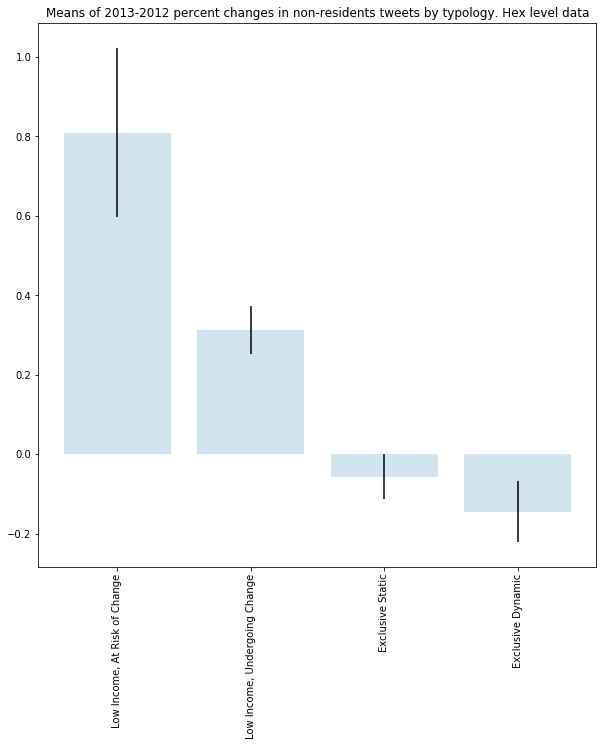

In [31]:
gdfchangesb=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2013,6,30), period_statistic="sum")
#1 Get centroids
gdfchanges_pointsb=myh3.df_with_hexid_to_centroids_gdf(gdfchangesb, hexcolname='_id')

# 3 Spatial Join between centroids and census track shapes
tweets_tractsb=gpd.sjoin(gdfchanges_pointsb, tracts, how="inner", op='intersects')

tweets_tractsb=tweets_tractsb.merge(typologies[['COD_2010','TYPE']], left_on='cod_radio', right_on='COD_2010')


typo_statsb=tweets_tractsb[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'TYPE']].groupby('TYPE').agg(['mean','count','sem'])
typo_statsb.reset_index(inplace=True)

tweets_tractsb.loc[tweets_tractsb.nonresidents_ch<8].nonresidents_ch.hist()

barchart(tweets_tractsb, 'nonresidents_ch', title='Means of 2013-2012 percent changes in non-residents tweets by typology. Hex level data')


# 4 Statistics at the Tract Level

## Spatially join the tract data to the hex level counts 

In [38]:
# Get counts at hex level 
df=a.hexcountsresults_to_df(db, save=False)


dfcentroids=myh3.df_with_hexid_to_centroids_gdf(df, hexcolname='_id')



# Spatial Join
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
tracts = gpd.read_file(currentdir+'/../data/radios_amba_2010.shp')

# Spatial Join between centroids and census track shapes
dfcentroids=gpd.sjoin(dfcentroids, tracts, how="inner", op='intersects')

# Since in my case I do not have the typologies with the census tract data, I still need to merge it by censustrackid
typologies=pd.read_excel(currentdir+'/../data/tipologias/'+'tipologias.xlsx')


typologies.loc[typologies['TYPE']=='GDV','TYPE' ]="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GD','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='GV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='G','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='DV','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='D','TYPE']="Low Income, Undergoing Change"
typologies.loc[typologies['TYPE']=='VE','TYPE']="Exclusive Dynamic"
typologies.loc[typologies['TYPE']=='V','TYPE']="Low Income, At Risk of Change"
typologies.loc[typologies['TYPE']=='E','TYPE']="Exclusive Static"


dfcentroids=dfcentroids.merge(typologies[['COD_2010','TYPE']], left_on='cod_radio', right_on='COD_2010')

/home/rickhunter/miniconda3/envs/twitteranalysis/lib/python3.6/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!(None != {'init': 'epsg:4326'})
  '(%s != %s)' % (left_df.crs, right_df.crs))


## Sum the hex tweets at the hex level, and merge typologies (again)

In [56]:
df_tract_level=dfcentroids[['nonresidents','nonresidentsandnonneighbors','residents','totalcounts','COD_2010','time']].groupby(['COD_2010','time']).sum().reset_index()
typologies_code=dfcentroids[['COD_2010','TYPE']].drop_duplicates()
df_tract_level=df_tract_level.merge(typologies_code, left_on='COD_2010', right_on='COD_2010')
df_tract_level.head(3)

,COD_2010,time,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,TYPE
0,20010101,2012-09-30,995.0,970.0,39.0,1034.0,"Low Income, Undergoing Change"
1,20010101,2012-12-31,1996.0,1969.0,66.0,2062.0,"Low Income, Undergoing Change"
2,20010101,2013-03-31,2756.0,2662.0,592.0,3348.0,"Low Income, Undergoing Change"


## Compute panel differences between periods. Remember to define the midpoint date. Also define the name of the tract code identifier

In [66]:
import numpy as np
def changebetweenperiods(df, datebeforeandafterperiod=datetime.datetime(2013,6,30), tractcode='COD_2010'):
    df['period']=np.where(df.time>datebeforeandafterperiod,1,0)
    df2=df.groupby([tractcode,'period']).mean()

    # Diferencias entre periodos para cada una de las variables
    df2dif=df2.groupby(tractcode)['nonresidents', 'nonresidentsandnonneighbors', 'residents', 'totalcounts'].diff(1)

    # Me voy a quedar por un lado con las diferencias en df2dif, y por otro lado con el periodo 0 en df20
    df2dif=df2dif.reset_index()
    df2dif=df2dif.loc[df2dif.period==1]
    #df2dif

    df2b=df2.reset_index()
    df20=df2b.loc[df2b.period==0]

    # Junto todo en un merge
    dfnew=df2dif.merge(df20, left_on=tractcode, right_on=tractcode, suffixes=('_dif', '_p0'))
    dfnew=dfnew.drop(columns=['period_dif', 'period_p0'])
    #dfnew

    # computo las tasas de crecimiento en las variables _ch
    for var in ['nonresidents', 'nonresidentsandnonneighbors','residents','totalcounts']:
        dfnew[var+'_ch']=dfnew[var+'_dif']/dfnew[var+'_p0']


    # Las versiones b de las tasas de crecimiento son solo las tasas para aquellos lugares que tenian mas de 50 tweets en periodo 0
    for var in ['nonresidents', 'nonresidentsandnonneighbors','residents','totalcounts']:
        dfnew[var+'_ch'+'b']=np.where(dfnew[var+'_p0']>50,dfnew[var+'_ch'],np.NaN)
        
    return dfnew

df_tract_level_changes=changebetweenperiods(df_tract_level, datebeforeandafterperiod=datetime.datetime(2013,6,30), tractcode='COD_2010')

# merging typologies again
df_tract_level_changes=df_tract_level_changes.merge(typologies_code, left_on='COD_2010', right_on='COD_2010')
df_tract_level_changes.head(5)

,COD_2010,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,TYPE
0,20010101,874.500000,850.000000,-138.250000,736.250000,2008.00,1960.00,205.25,2213.25,0.435508,0.433673,-0.673569,0.332656,0.435508,0.433673,-0.673569,0.332656,"Low Income, Undergoing Change"
1,20010201,557.250000,556.250000,9.000000,566.250000,73.75,72.25,6.50,80.25,7.555932,7.698962,1.384615,7.056075,7.555932,7.698962,NaN,7.056075,"Low Income, At Risk of Change"
2,20010212,21.750000,86.250000,11.500000,33.250000,175.75,108.75,7.00,182.75,0.123755,0.793103,1.642857,0.181943,0.123755,0.793103,NaN,0.181943,"Low Income, At Risk of Change"
3,20010306,230.416667,-21.833333,-8.500000,221.916667,158.25,100.50,8.50,166.75,1.456029,-0.217247,-1.000000,1.330835,1.456029,-0.217247,NaN,1.330835,"Low Income, At Risk of Change"
4,20010321,350.250000,329.833333,193.333333,543.583333,2145.75,2106.50,53.00,2198.75,0.163230,0.156579,3.647799,0.247224,0.163230,0.156579,3.647799,0.247224,"Low Income, At Risk of Change"


In [72]:
# Statistics
df_tract_level_changesb=df_tract_level_changes[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'TYPE']].groupby('TYPE').agg(['mean','count','sem'])
df_tract_level_changesb.reset_index(inplace=True)
df_tract_level_changesb


TYPE nonresidents_dif                    \
                                             mean count         sem   
0              Exclusive Dynamic       375.472222    15  137.287828   
1               Exclusive Static       315.421970   110   42.349887   
2  Low Income, At Risk of Change       393.394900   134   38.225800   
3  Low Income, Undergoing Change       376.844865   607   18.960132   
4                        NON POP       140.625000     2    2.125000   
5                        NON_POP       647.050000     5  432.946782   
6                          OTHER       318.445833    20   70.130099   

  nonresidents_ch                 nonresidents_p0                     
             mean count       sem            mean count          sem  
0        0.149390    15  0.053508     2227.083333    15   278.689564  
1        0.292393   110  0.045486     1764.697727   110   105.214357  
2        1.296719   134  0.160093      596.248134   134    46.793108  
3        0.775416   607  0.043273      816.268534   607    30.112855  
4        0.680310     2  0.060332      208.625000     2    21.625000  
5        1.005436     5  0.464647     2281.550000     5  1932.467418  
6        0.842019    20  0.329953      957.587500    20   184.311191

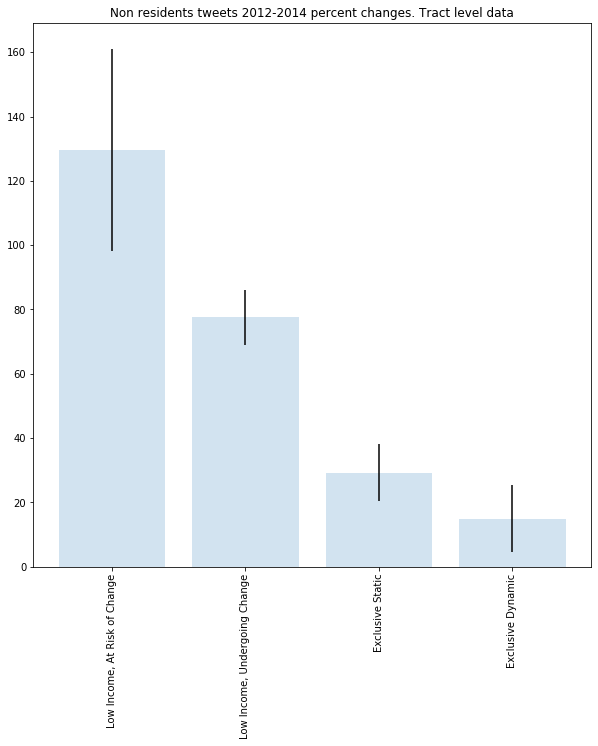

In [80]:

def newbarchart(df,title='insert title'):
    df=df.sort_values(by=('nonresidents_ch','mean'), ascending=False)

    df=df.loc[df.TYPE!='NON_POP']
    df=df.loc[df.TYPE!='NON POP']
    df=df.loc[df.TYPE!='OTHER']

    # notice I am multiplying by 100 because I did not do previously
    fig, ax = plt.subplots()
    ax.bar(df['TYPE'], df['nonresidents_ch','mean']*100, yerr=1.96*df['nonresidents_ch','sem']*100, alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
newbarchart(df_tract_level_changesb,title='Non residents tweets 2012-2014 percent changes. Tract level data')